# Exploring Fires

This notebook goes over: 
- the basics of loading, removing clouds, and clipping satellite imagery data to a region of interest from GEE using geemap interactive maps
- Loading polygons from natural earth data as geopandas
- Interacting with the FIRMS API to extract hotspot data for VIIRS & MODIS
- Plotting hotspot data overtop of Canada
- How to project data for buffering and applying buffers in Python
- Exploring NBAC data and NFDB data (polygons & point data)
- Exploring the CFSDS and learning how to upload tif files and plotting them on top of maps

## Notes

A lot of this info taken from: https://www.earthdata.nasa.gov/faq/firms-faq

### Images vs ImageCollections in GEE

**Images**

- Definition: A single raster image, which can represent satellite imagery, aerial photographs, or any other pixel-based data.
- Usage: Useful for analyzing specific timeframes or particular data points. For example, a single Landsat image captured on a specific date.
- Operations: You can perform operations like masking, pixel-wise calculations, or applying algorithms to the image.
    
**Image Collections**

- Definition: A stack of images that share the same spatial extent and usually the same sensor type but differ in time or other parameters.
- Usage: Ideal for temporal analysis, like observing changes over time or generating time series analyses. For instance, a collection of Landsat images from multiple years.
- Operations: You can apply functions over the collection, such as filtering by date, calculating median values, or computing statistics across images.
- Key Differences
- Structure: Images are singular, while image collections are aggregations of multiple images.
- Analysis: Image collections facilitate analysis over time, while images focus on single observations.
- Functionality: Collections allow batch processing and more complex operations, such as time series analysis.

### Smoke and Cloud Cover in Imagery

Removing smoke and cloud cover from satellite imagery is crucial for accurate analysis. Here are common techniques used in remote sensing to achieve this:

1. **Cloud Masking**
- Cloud Detection Algorithms: Algorithms like the Moderate Resolution Imaging Spectroradiometer (MODIS) cloud mask can identify cloudy pixels based on their brightness and reflectance characteristics.
- Thresholding: Setting thresholds for certain spectral bands (e.g., using the red and near-infrared bands) to distinguish clouds from clear pixels.
  
2. **Smoke Detection**
- Spectral Analysis: Smoke has distinct spectral signatures, particularly in the shortwave infrared range. Algorithms can use these signatures to identify and mask smoke-affected pixels.
- Aerosol Detection: Utilizing algorithms that identify aerosols, which can indicate the presence of smoke.
  
3. **Temporal Filtering**
- Image Stacking: Using multiple images over time to identify and replace cloudy or smoky pixels with data from clear days.
- Composite Images: Creating composite images (e.g., using the median or maximum value) to minimize the impact of clouds and smoke.
  
4. **Statistical Techniques**
- Machine Learning: Training models to classify and remove cloud and smoke pixels based on labeled datasets.
- Spectral Unmixing: Decomposing mixed pixels to separate cloud and smoke contributions from the underlying surface.

6. **Radiative Transfer Models**
- Modeling Atmospheric Effects: Using models to simulate how clouds and smoke affect the satellite signal, allowing for corrections in the imagery.

8. **Post-Processing Techniques**
- Interpolation: Filling gaps in data where clouds or smoke obscured the view by interpolating values from surrounding clear pixels.
- Geometric Correction: Ensuring that cloud and smoke removals don't distort the spatial accuracy of the imagery.
- By combining these methods, analysts can effectively reduce the impact of clouds and smoke, leading to clearer and more usable satellite imagery for various applications.

### MODIS vs VIIRS reso
![title](images/MODIS.png)
![title](images/VIIRS.png)

### Different Data Sources 

#### Hot spots ("Active fire detections") (Sensor/Platform):
- Can be pulled from GEE or FIRMS
- **MODIS/(Terra, Aqua)**: 1 km, Global
- **VIIRS/(Suomi NPP, NOAA-20, NOAA-21)**: 375 m, Global, the orbit of NOAA-21 is about 50 minutes ahead of NOAA-20 with Soumi NPP orbiting between them
- **OLI/(Landsat 8 & 9)**: 30 m, US-Canada
- **ABI/(GOES-16 & 18)**: 2 km sub-satellite, Americas
- **SEVIRI/(Meteosat 9 & 11)**: 2 km sub-satellite, Europe-Africa-India
- **AHI/(Himawari-8)**: 2 km sub-satellite, Australia/Asia

#### Fire Perimeters Canada: 
- **NBAC** (polygons): https://cwfis.cfs.nrcan.gc.ca/datamart/metadata/nbac
    - NBAC stands for the National Burned Area Composite, calculates the area of forest burned on a national scale for each year since 1972 (currently up to 2024-05-30)
    - Created using Sentinel & Landsat data
    - Fire perimeter map comprising a vector representation of the outer edge of the burned area, with unburned vegetated island features and water removed
    - Uses:
       - CNFDB (agency fire polygon data)
       - In areas where detail is course, Landsat imagery processed through MAFiMS (multi-aquisition fire mapping system)
       - SPOT VEGETATION/Proba-V imagery and HANDS algorithm provide burned area polygons where not reported by agency or MAFiMS

- **NFDB** (point and polygons): https://cwfis.cfs.nrcan.gc.ca/datamart/metadata/nfdbpoly, https://cwfis.cfs.nrcan.gc.ca/ha/nfdb?type=pnt&year=9999
    - NFDB stands for National Fire Database
    - the polygon data only goes to 2021, so we'll use the point data which goes to 2023

From ChatGPT:

In Canada, the **National Burned Area Composite (NBAC)** and the **National Fire Database (NFD)** serve different purposes in wildfire management and research.

1. **National Burned Area Composite (NBAC)**:
   - This is a satellite-based product that provides information on the areas burned by wildfires. 
   - It typically offers updated maps and data about burned regions, helping to assess the extent and severity of fire impacts.
   - The NBAC is useful for monitoring and reporting on recent fires, as well as for planning recovery efforts.

2. **National Fire Database (NFD)**:
   - This is a comprehensive database that collects information about wildfires across Canada, including details such as fire causes, sizes, locations, and response actions.
   - The NFD serves as a historical record and supports analysis of fire trends over time.
   - It is often used for research, policy development, and fire management planning.

In summary, the NBAC focuses on providing real-time and satellite-derived information about burned areas, while the NFD offers a broader historical perspective on fire incidents across Canada.

#### Canadian Fire Spread Dataset: 
- **CFSDS**: https://osf.io/f48ry/
   - an event-based fire growth database built on the combination of high-precision fire event boundaries and multi-sensor active fire detections

#### SP vs. URT/NRT/RT
- Standard data are internally consistent, well-calibrated record 
- URT (ultra real-time), RT (real-time), AND NRT (near real-time) are made more quickly than standard processing to support environmental monitoring, response to hazard/disaster events, etc.
- NRT provide data within 1-3 hours of satellite overpass
- RT and URT are predicted on raw satellite data collected via direct readout ground stations



# Questions

1. How are the fire perimeters made? NBAC is assumed to be the most consistent fire perimeters and this is made using Landsat & Sentinel, but what about hotspots predicted using different tools on different satellites? Ex. VIIRS & MODIS - the tools on these satellites then aren't used to create the fire perimeters, so comparing these hotspots seems a bit odd if they weren't created using the same tools
2. EPSG 4249 was used in the CFSDS (this is NAD39), I've been using 4326 (WGS84) as I saw online that would be the most "common" - is there a default I should be using? And how important is it for me to understand these in depth? https://gis.stackexchange.com/questions/170839/is-re-projection-needed-from-srid-4326-wgs-84-to-srid-4269-nad-83
3. CFSDS - what exactly is the NFIREID colourbar showing? Specific fires within the same... what?
4. Why do NOAA20 and SNPP have different hot spot results? See FIRMS data - how do they have different results for the same day?
5. I was trying to export a clipped image data from GEE using LandSat data but I couldn't figure it out :( It keeps outputting square blocks, is this a useful tool to keep looking into? How do you visualize satellite data in Python?

**Overall Q**:
- Still not really sure how to look for plumes.
- Hot spots outside of fire perimeters:
   - The fire perimeters are created with Landsat and Sentinel data
   - Specifically we're trying to look at plumes which have been incorrectly identified as fire (active fire detection) from the VIIRS instrument which is on NOAA-20/21/SUOMI-NPP
- Image data: How should I be interacting with image data to try to confirm if things are a plume or a fire? I have loaded the image data now but I'm not sure what I'm looking for 


# Loading Imagery with GEE

In [1]:
import ee
import geemap
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import CRS
from cartopy import crs as ccrs
from geodatasets import get_path
import rioxarray as rxr 
import matplotlib.patches as mpatches
import time

from osgeo import gdal
gdal.SetConfigOption('SHAPE_RESTORE_SHX', 'YES')

ee.Authenticate()
ee.Initialize(project='karlzam')

In [2]:
startDate = '2023-09-22'
endDate = '2023-10-24'

In [3]:
Map = geemap.Map()

# Large scale international boundary polygons, simplified
countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")

# Using swaziland as an example because it's small
roi = countries.filter(ee.Filter.eq("country_na", "Canada"));

# Get map
Map.addLayer(roi, {}, "Canada")

# Center the object at the region of interest with a zoom of 8
Map.centerObject(roi,4)

# Load in landsat data with filter
# Originally this covers the entire world over a long time series 
landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1").filterDate(startDate, endDate).filterBounds(roi)

# Remove clouds
composite = ee.Algorithms.Landsat.simpleComposite(**{
    'collection': landsat,
    'asFloat': True
})

# Define landsat bands we'll be using 
rgbVis = {'bands': ['B4', 'B3', 'B2'], 'min':0, 'max':0.3}

Map.addLayer(composite.clip(roi), rgbVis, "Landsat RGB")

In [4]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)


dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate(startDate, endDate)
    # Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .map(mask_s2_clouds)
)

visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

Map.add_layer(dataset.mean(), visualization, 'RGB-Sentinel')

In [5]:
# FIRMS
# MODIS fire thermal anomalies 
# Active fire locations 

burned_areas_FIRMS = ee.ImageCollection("FIRMS").filterDate(startDate, endDate)
fires = burned_areas_FIRMS.select('T21')

firesVis = {'min': 0, 'max': 500.0, 'palette': ['red', 'orange', 'yellow']}

Map.addLayer(fires, firesVis, "FIRMS")

In [6]:
# Adds MODIS Burned Area
# Monthly per pixel burned area and quality info (500m)

burned_areas_MODIS = ee.ImageCollection("MODIS/061/MCD64A1").filterDate(startDate, endDate)
burnedAreaMODIS = burned_areas_MODIS.select('BurnDate')
burnedAreaVis = {
  'min': 30.0,
  'max': 341.0,
  'palette': ['4e0400', '951003', 'c61503', 'ff1901'],
}
Map.addLayer(burnedAreaMODIS, burnedAreaVis, 'MODIS')

In [7]:
# Launch map
Map

Map(center=[60.558438200875784, -96.70702570923024], controls=(WidgetControl(options=['position', 'transparent…

# Exploring Sources

## Get province polygons

In [8]:
# Province polygons from natural earth data 
# Subset so it's only Alberta, BC, and Sask (arbitrary bc this is where I've extracted some FIRMS data for exploration)
shp_map = gpd.read_file(r'C:\Users\kzammit\Documents\Shapefiles\Natural-Earth\ne_10m_admin_1_states_provinces.shp')
ab_bc_ma_map = shp_map[(shp_map['name']=='Alberta') | (shp_map['name']=='British Columbia') | (shp_map['name']=='Saskatchewan')]
ab_bc_ma_map.head()

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
1236,Admin-1 states provinces,2,CAN-633,633,CA-BC,http://en.wikipedia.org/wiki/British_Columbia,CA,3,British Columbia,Colombie britannique|New Caledonia,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-117.03815 48.99251, -117.1580..."
1239,Admin-1 states provinces,2,CAN-632,632,CA-AB,http://en.wikipedia.org/wiki/Alberta,CA,1,Alberta,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-109.99932 48.99262, -110.1241 48.99..."
1240,Admin-1 states provinces,2,CAN-631,631,CA-SK,http://en.wikipedia.org/wiki/Saskatchewan,CA,1,Saskatchewan,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-104.04757 48.99262, -104.18924 48.9..."


## Persistent Hot Spots
These are known hotspots that commonly trigger false positives in fire detection 

In [9]:
# Get persistent hot spots (these are from Piyush)
persistent_hs = gpd.read_file(r'C:\Users\kzammit\Documents\Shapefiles\persistent_heat_sources\m3mask5_lcc.shp')
persistent_hs_sub = persistent_hs[(persistent_hs['prov']=='AB') | (persistent_hs['prov']=='BC') | (persistent_hs['prov']=='SK')]
persistent_hs_sub = persistent_hs_sub.to_crs(epsg=4326)

## Firms Data
This is the alternative method of extracting FIRMS data other than using GEE

Extracted for a somewhat random region containing some of BC, all of AB, and some of MB

Links to google collab tutorials: 
- API: https://colab.research.google.com/drive/1TRxYja1d7pbZOq0aKx2SZJAw_aF-RCZ9
- Viz: https://colab.research.google.com/drive/1YDAktkP41_bpvJIcx5Rg1GF0tx22XnfQ
- Data: https://colab.research.google.com/drive/1LMKJ4Y_8fk4UBNeeUS_1QV5aaFGjQq7J

In [10]:
MAP_KEY = 'e865c77bb60984ab516517cd4cdadea0'
url = 'https://firms.modaps.eosdis.nasa.gov/mapserver/mapkey_status/?MAP_KEY=' + MAP_KEY
try:
  df = pd.read_json(url,  typ='series')
  display(df)
except:
  # possible error, wrong MAP_KEY value, check for extra quotes, missing letters
  print ("There is an issue with the query. \nTry in your browser: %s" % url)

transaction_limit             5000
current_transactions            26
transaction_interval    10 minutes
dtype: object

In [11]:
path = get_path("naturalearth.land")
world = gpd.read_file(path)

In [12]:
# VIIRS_NOAA20_NRT
area_url_NOAA20 = 'https://firms.modaps.eosdis.nasa.gov/api/area/csv/' + MAP_KEY + '/VIIRS_NOAA20_NRT/-125.6,48.9,-103,60.1/1/2023-09-23'
df_NOAA20 = pd.read_csv(area_url_NOAA20)
gdf_NOAA20 = gpd.GeoDataFrame(
    df_NOAA20, geometry=gpd.points_from_xy(df_NOAA20.longitude, df_NOAA20.latitude), crs="EPSG:4326"
)
gdf_NOAA20.head(3)

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,geometry
0,58.18467,-103.05048,297.48,0.44,0.63,2023-09-23,756,N20,VIIRS,n,2.0NRT,282.61,1.47,N,POINT (-103.05048 58.18467)
1,58.28116,-104.21061,301.68,0.49,0.65,2023-09-23,756,N20,VIIRS,n,2.0NRT,280.74,0.94,N,POINT (-104.21061 58.28116)
2,58.29360,-104.15102,296.12,0.49,0.65,2023-09-23,756,N20,VIIRS,n,2.0NRT,279.39,2.52,N,POINT (-104.15102 58.2936)


In [13]:
# S-NPP & NOAA-20 
# There's standard processing and NRT, but NRT was only available for 2024 so using NRT
area_url_SNPP = 'https://firms.modaps.eosdis.nasa.gov/api/area/csv/' + MAP_KEY + '/VIIRS_SNPP_SP/-125.6,48.9,-103,60.1/1/2023-09-23'
df_SNPP = pd.read_csv(area_url_SNPP)
gdf_SNPP = gpd.GeoDataFrame(
    df_SNPP, geometry=gpd.points_from_xy(df_SNPP.longitude, df_SNPP.latitude), crs="EPSG:4326"
)
gdf_SNPP.head(3)

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type,geometry
0,58.18359,-103.04836,316.95,0.48,0.40,2023-09-23,847,N,VIIRS,n,2,283.80,2.48,N,0,POINT (-103.04836 58.18359)
1,58.22665,-121.76677,300.05,0.72,0.76,2023-09-23,847,N,VIIRS,n,2,281.87,5.35,N,0,POINT (-121.76677 58.22665)
2,58.22910,-121.71581,295.78,0.72,0.76,2023-09-23,847,N,VIIRS,n,2,283.09,2.08,N,0,POINT (-121.71581 58.2291)


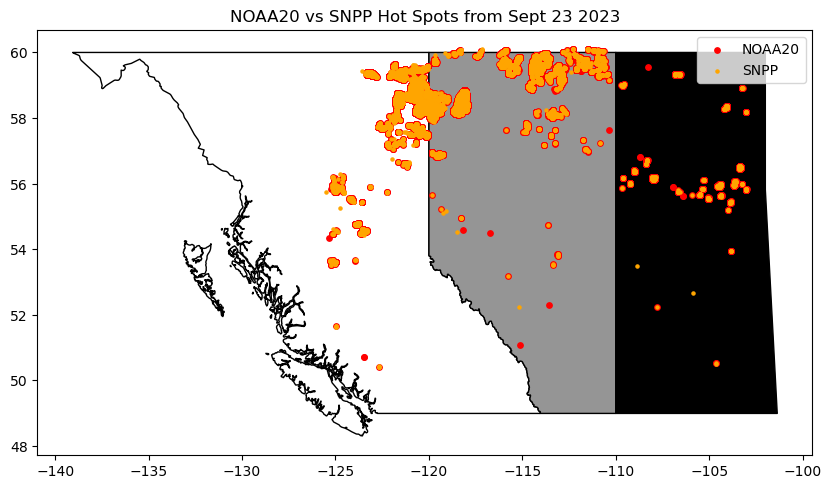

In [14]:
fig, ax = plt.subplots(figsize=(10,8))
ab_bc_ma_map.plot(ax=ax, edgecolor='black', linewidth=1, cmap='Greys')
gdf_NOAA20.plot(ax=ax, color='red', markersize=15, label='NOAA20')
gdf_SNPP.plot(ax=ax, color='orange', markersize=5, label='SNPP')
plt.title('NOAA20 vs SNPP Hot Spots from Sept 23 2023')
plt.legend()

NOAA20 and SNPP have different results (with overlap) as...

## NBAC

In [15]:
NBAC = gpd.read_file(r'C:\Users\kzammit\Documents\Shapefiles\NBAC\nbac_1972_2023_20240530.shp')
NBAC = NBAC.to_crs(epsg=4326)
NBAC.head()

,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,HS_SDATE,HS_EDATE,AG_SDATE,AG_EDATE,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLAG,ADMIN_AREA,NATPARK,PRESCRIBED,VERSION,GID,geometry
0,2022.0,439.0,MAFiMS,Sentinel-2,Processed imagery,Natural,2022/06/28,2022/10/02,2022/06/26,0000/00/00,2022/09/16,45023.957801,45023.957801,None,AB,None,None,20240530,2022_439,"MULTIPOLYGON (((-111.2759 58.9938, -111.27538 ..."
1,2022.0,74.0,MAFiMS,Sentinel-2,Processed imagery,Natural,2022/07/07,2022/07/08,2022/07/08,2022/07/18,2022/09/08,737.755249,737.755249,None,NT,None,None,20240530,2022_74,"MULTIPOLYGON (((-105.28646 60.29696, -105.2863..."
2,2022.0,149.0,MAFiMS,Landsat,Processed imagery,Natural,2022/07/08,2022/08/26,2022/06/21,2022/11/03,2022/10/22,9572.430492,9572.430492,None,NT,None,None,20240530,2022_149,"MULTIPOLYGON (((-122.17543 61.9815, -122.17572..."
3,2022.0,156.0,MAFiMS,Sentinel-2,Processed imagery,Natural,2022/08/17,2022/10/03,2022/08/18,2022/10/27,2022/10/17,26761.761894,26761.761894,None,NT,None,None,20240530,2022_156,"MULTIPOLYGON (((-111.28776 60.15918, -111.2875..."
4,2022.0,281.0,MAFiMS,Sentinel-2,Processed imagery,Undetermined,2022/07/04,2022/07/07,0000/00/00,0000/00/00,2022/08/23,400.728797,400.728797,None,YT,None,None,20240530,2022_281,"MULTIPOLYGON (((-135.40711 63.96983, -135.4071..."


In [16]:
NBAC['YEAR'].unique()

array([2022., 1972., 1973., 1974., 1975., 1976., 1977., 1978., 1979.,
       1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988.,
       1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997.,
       1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006.,
       2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
       2016., 2017., 2018., 2019., 2020., 2021., 2023.])

In [17]:
# Let's chop this down to just 2023
NBAC_23 = NBAC[NBAC['YEAR']==2023.0]
NBAC_23.head()

,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,HS_SDATE,HS_EDATE,AG_SDATE,AG_EDATE,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLAG,ADMIN_AREA,NATPARK,PRESCRIBED,VERSION,GID,geometry
46740,2023.0,217.0,MAFiMS,Sentinel-2,Processed imagery,Natural,2023/07/12,2023/08/25,2023/06/29,0000/00/00,2023/09/30,43522.445118,43522.445118,None,NT,None,None,20240530,2023_217,"MULTIPOLYGON (((-113.94436 62.73676, -113.9443..."
46741,2023.0,337.0,MAFiMS,Sentinel-2,Processed imagery,Natural,2023/06/29,2023/09/20,2023/06/29,2023/09/06,2023/09/16,17565.255407,17565.255407,None,NT,None,None,20240530,2023_337,"MULTIPOLYGON (((-125.86883 64.16122, -125.8688..."
46742,2023.0,690.0,MAFiMS,Sentinel-2,Processed imagery,Undetermined,2023/06/10,2023/09/24,0000/00/00,0000/00/00,2023/10/08,3429.823905,3429.823905,None,AB,None,None,20240530,2023_690,"MULTIPOLYGON (((-114.85002 57.52101, -114.8498..."
46743,2023.0,216.0,MAFiMS,Sentinel-2,Processed imagery,Natural,2023/06/09,2023/07/22,2023/06/05,2023/09/01,2023/09/15,1130.420703,1130.420703,None,NT,None,None,20240530,2023_216,"MULTIPOLYGON (((-121.16414 61.14514, -121.1646..."
46744,2023.0,654.0,MAFiMS,Landsat,Processed imagery,Natural,2023/07/26,2023/07/30,2023/07/26,2023/08/06,2023/08/15,3929.060214,3929.060214,None,SK,None,None,20240530,2023_654,"MULTIPOLYGON (((-107.32077 58.99124, -107.3207..."


<Axes: >

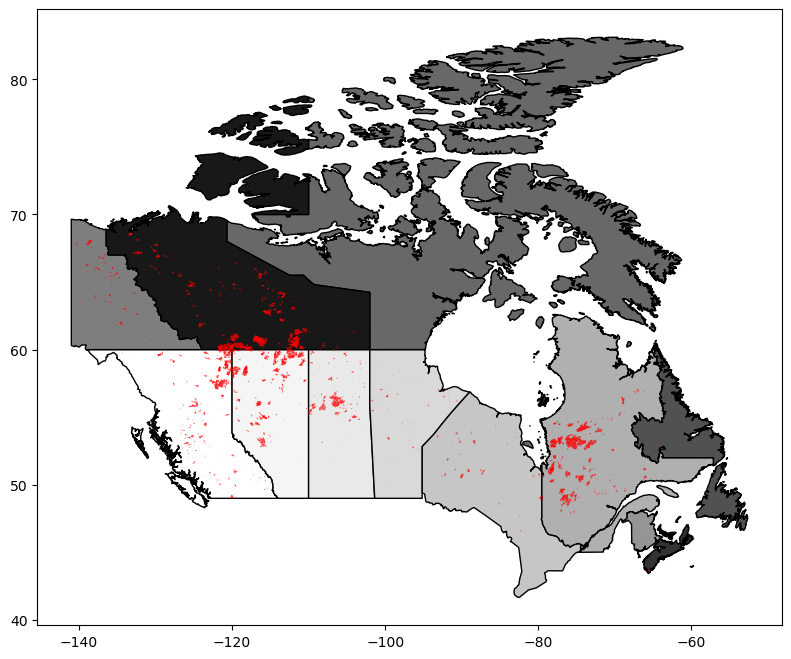

In [18]:
# Plot the NBAC polygons
fig, ax = plt.subplots(figsize=(10,8))
shp_map_cad = shp_map[shp_map['iso_a2']=='CA']
shp_map_cad.plot(ax=ax, edgecolor='black', linewidth=1, cmap='Greys')
NBAC_23.plot(ax=ax, linewidth=1, color='red')

In [19]:
# In QGIS I randomly picked a large polygon to look at in more detail as some hotspots were located outside of it 
# In order to account for the fact that hotspots are usually placed in the middle of a fire pixel, not at the exact location due to the resolution of the satellite, we add a 5 km buffer to the existing polygon to allow for some deviation in the placement
# The buffer takes a while to compute so save it once it's done and read it in instead of running again 

#subset_poly = gpd.read_file(r'C:\Users\kzammit\Documents\Sept23-Fire\subset-poly-2.shp')
#gdf_projected = subset_poly.to_crs(CRS(32610))
#buffer_distance = 5000  # 5 km in meters
#gdf_buffered = gdf_projected.copy()
#gdf_buffered['geometry'] = gdf_projected.buffer(buffer_distance)
#gdf_buffered = gdf_buffered.to_crs(epsg=4326)
#gdf_buffered.to_file(r'C:\Users\kzammit\Documents\Sept23-Fire\buffer-polygon-2.shp')

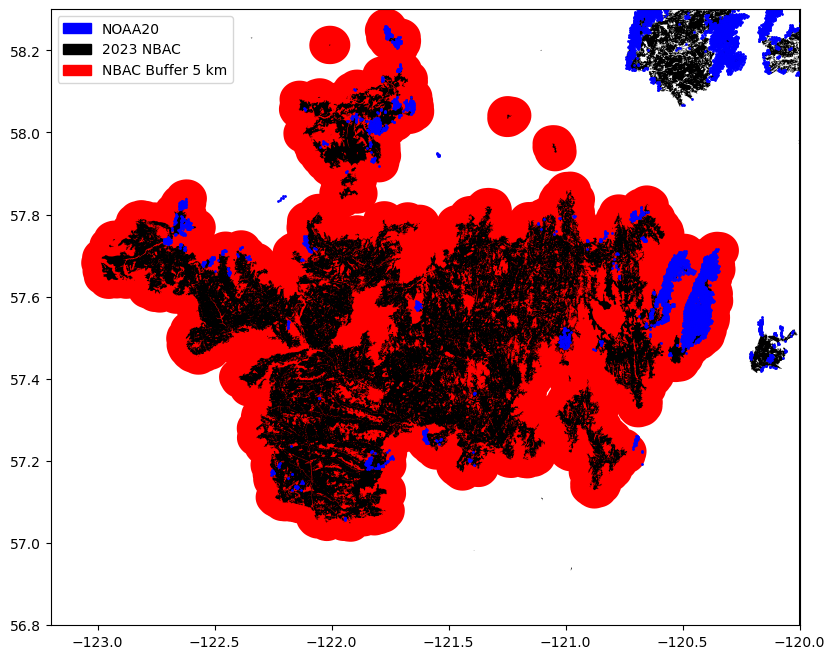

In [20]:
# There are two hotspots here unaccounted for in the buffered NBAC data 
buffer_poly = gpd.read_file(r'C:\Users\kzammit\Documents\Sept23-Fire\buffer-polygon-2.shp')

fig, ax = plt.subplots(figsize=(10,8))
ab_bc_ma_map.plot(ax=ax, edgecolor='black', linewidth=1, cmap='Greys')
buffer_poly.plot(ax=ax, linewidth=10, color='red')
NBAC_23.plot(ax=ax, linewidth=10, color='black')
gdf_NOAA20.plot(ax=ax, color="blue", markersize=1)

blue_patch = mpatches.Patch(color='blue', label='NOAA20')
black_patch = mpatches.Patch(color='black', label='2023 NBAC')
red_dots = mpatches.Patch(color='red', label='NBAC Buffer 5 km')
ax.legend(handles=[blue_patch, black_patch, red_dots])

plt.ylim((56.8, 58.3))
plt.xlim((-123.2, -120))
plt.show()

### Export Image Data for Subset Poly

Idea here was to create a large buffer around the fire polygon, get a snippet of the image data using GEE, and then export the snippet to a tif file so I could plot it overtop of the buffer plot above - but it did not work :(

In [21]:
# Create a much larger buffer distance so we can see image data for potential hotspots from that time 
#buffer_poly = gpd.read_file(r'C:\Users\kzammit\Documents\Sept23-Fire\buffer-polygon-2.shp')
#buffer_distance = 30000
#gdf_projected_2 = buffer_poly.to_crs(CRS(32610))# 5 km in meters
#gdf_buffered_2 = gdf_projected_2.copy()
#gdf_buffered_2['geometry'] = gdf_buffered_2.buffer(buffer_distance)
#gdf_buffered_2 = gdf_buffered_2.to_crs(epsg=4326)
#gdf_buffered_2.to_file(r'C:\Users\kzammit\Documents\Sept23-Fire\buffer-polygon-large.shp')

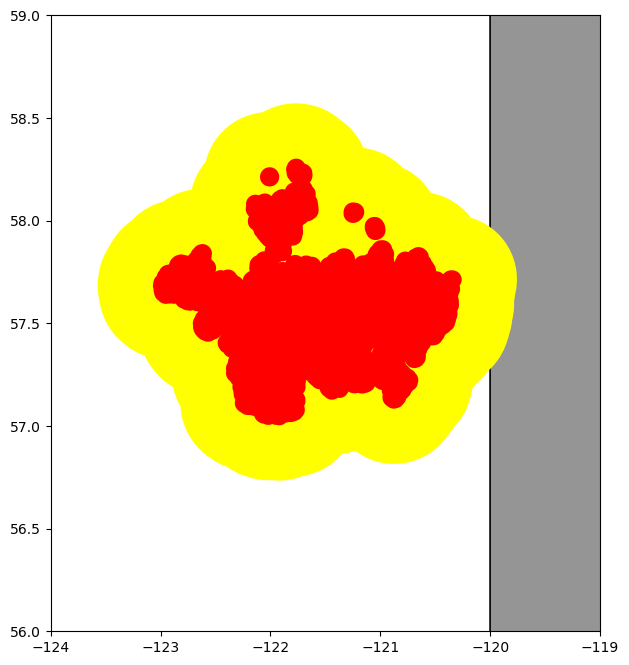

In [22]:
# Plot the old and new buffer to see what space we'll be looking at
buffer_poly = gpd.read_file(r'C:\Users\kzammit\Documents\Sept23-Fire\buffer-polygon-2.shp')
buffer_poly_large = gpd.read_file(r'C:\Users\kzammit\Documents\Sept23-Fire\buffer-polygon-large.shp')

fig, ax = plt.subplots(figsize=(10,8))
ab_bc_ma_map.plot(ax=ax, edgecolor='black', linewidth=1, cmap='Greys')
buffer_poly_large.plot(ax=ax, linewidth=10, color='yellow')
buffer_poly.plot(ax=ax, linewidth=10, color='red')

plt.ylim((56, 59))
plt.xlim((-124, -119))
plt.show()

In [23]:
Map2 = geemap.Map() 

# The shapefile is in the form of a geodataframe, and so we need to convert it to an EE feature collection before we can use it as an roi
large_buffer = gpd.read_file(r'C:\Users\kzammit\Documents\Sept23-Fire\buffer-polygon-large.shp')
roi_2 = geemap.geopandas_to_ee(large_buffer)

Map2.addLayer(roi_2, {}, "Buffer")
Map2.centerObject(roi_2, 7)

Map2

Map(center=[57.728239976126844, -121.55316450391153], controls=(WidgetControl(options=['position', 'transparen…

In [24]:
burned_areas_FIRMS = ee.ImageCollection("FIRMS").filterDate(startDate, endDate)
fires = burned_areas_FIRMS.select('T21')

firesVis = {'min': 0, 'max': 500.0, 'palette': ['red', 'orange', 'yellow']}

Map2.addLayer(fires, firesVis, "FIRMS")

In [25]:
# buffer_poly.plot(ax=ax, linewidth=10, color='red') 

In [26]:
# Now let's crop the satellite image data to the new feature polygon
region = ee.Geometry.BBox(-124, 56, -119, 59)
# Load in landsat data with filter
# Originally this covers the entire world over a long time series 
landsat_2 = ee.ImageCollection("LANDSAT/LC08/C02/T1").filterDate(startDate, endDate).filterBounds(roi_2)

# Remove clouds
composite = ee.Algorithms.Landsat.simpleComposite(**{
    'collection': landsat,
    'asFloat': True
})

# Define landsat bands we'll be using 
rgbVis = {'bands': ['B4', 'B3', 'B2'], 'min':0, 'max':0.3}
rgbVis2 = {'bands': ['B4', 'B3', 'B2']}

Map2.addLayer(landsat_2, rgbVis2, "Landsat w Clouds")
Map2.addLayer(composite.clip(roi_2), rgbVis, "Landsat RGB")

### Exporting to Google Drive

In [27]:
task = ee.batch.Export.image.toDrive(
    image=composite.visualize(bands=['B4', 'B3', 'B2'], min=0, max=0.3),
    description='test-3',
    crs='EPSG:4326',
    region=region,
    fileFormat = "GeoTIFF"
)
task.start()

while task.active():
    print('Polling for task (id: {}).'.format(task.id))
    time.sleep(5)

print('Task completed with status: ', task.status())

Polling for task (id: KK5YFWCL4U6VBZO556GZQQ2Q).
Polling for task (id: KK5YFWCL4U6VBZO556GZQQ2Q).
Polling for task (id: KK5YFWCL4U6VBZO556GZQQ2Q).
Polling for task (id: KK5YFWCL4U6VBZO556GZQQ2Q).
Polling for task (id: KK5YFWCL4U6VBZO556GZQQ2Q).
Polling for task (id: KK5YFWCL4U6VBZO556GZQQ2Q).
Polling for task (id: KK5YFWCL4U6VBZO556GZQQ2Q).
Task completed with status:  {'state': 'COMPLETED', 'description': 'test-3', 'priority': 100, 'creation_timestamp_ms': 1727973270203, 'update_timestamp_ms': 1727973304237, 'start_timestamp_ms': 1727973276319, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/'], 'attempt': 1, 'batch_eecu_usage_seconds': 10.091512680053711, 'id': 'KK5YFWCL4U6VBZO556GZQQ2Q', 'name': 'projects/karlzam/operations/KK5YFWCL4U6VBZO556GZQQ2Q'}


## NFDB

In [28]:
# Not continuing with this data source for now as it only goes up to 2021
NFDB = gpd.read_file(r'C:\Users\kzammit\Documents\Shapefiles\CWFIS-NFDB\NFDB_poly_20210707.shp')
NFDB = NFDB.to_crs(epsg=4326)
NFDB.head()

,SRC_AGENCY,FIRE_ID,FIRENAME,YEAR,MONTH,DAY,REP_DATE,DATE_TYPE,OUT_DATE,DECADE,...,UNBURN_REM,MORE_INFO,POLY_DATE,CFS_REF_ID,CFS_NOTE1,CFS_NOTE2,AG_SRCFILE,ACQ_DATE,SRC_AGY2,geometry
0,BC,2004-C10175,None,2004,6,23,2004/06/23,Report date,0000/00/00,2000-2009,...,None,None,2007/05/17,BC-2004-C10175,None,None,H_FIRE_PLY,2011/06/10,BC,"POLYGON Z ((-124.6106 53.08084 0, -124.6099 53..."
1,BC,2004-C10176,None,2004,6,23,2004/06/23,Report date,0000/00/00,2000-2009,...,None,None,2007/05/17,BC-2004-C10176,None,None,H_FIRE_PLY,2011/06/10,BC,"POLYGON Z ((-124.48262 53.06162 0, -124.4815 5..."
2,BC,2004-C50114,None,2004,6,20,2004/06/20,Report date,0000/00/00,2000-2009,...,None,None,2007/05/17,BC-2004-C50114,None,None,H_FIRE_PLY,2011/06/10,BC,"POLYGON Z ((-125.1276 52.13023 0, -125.12726 5..."
3,BC,2004-C50125,None,2004,6,21,2004/06/21,Report date,0000/00/00,2000-2009,...,None,None,2007/05/17,BC-2004-C50125,None,None,H_FIRE_PLY,2011/06/10,BC,"POLYGON Z ((-125.75419 52.27968 0, -125.75294 ..."
4,BC,2004-C50149,None,2004,6,22,2004/06/22,Report date,0000/00/00,2000-2009,...,None,None,2007/05/17,BC-2004-C50149,None,None,H_FIRE_PLY,2011/06/10,BC,"POLYGON Z ((-126.26477 52.9988 0, -126.26379 5..."


In [29]:
NFDB_point = gpd.read_file(r'C:\Users\kzammit\Documents\Shapefiles\CWFIS-NFDB\NFDB_point_20240613.shp')
NFDB_point_23 = NFDB_point[NFDB_point['YEAR']==2023]
NFDB_sep_23 = NFDB_point_23[NFDB_point_23['MONTH']==9]
#NFDB_sep_23 = NFDB_sep_23[NFDB_sep_23['DAY']==23]
NFDB_sep_23 = NFDB_sep_23.to_crs(epsg=4326)
NFDB_sep_23.head()

,NFDBFIREID,SRC_AGENCY,NAT_PARK,FIRE_ID,FIRENAME,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,...,CAUSE2,FIRE_TYPE,RESPONSE,PROTZONE,PRESCRIBED,MORE_INFO,CFS_NOTE1,CFS_NOTE2,ACQ_DATE,geometry
0,BC-2023-2023-C23369,BC,None,2023-C23369,C23369,51.8197,-122.0729,2023,9,27,...,H,Fire,FUL,None,None,NE of Alkali Creek,None,None,2024/05/06,POINT Z (-122.07285 51.81973 0)
15,BC-2023-2023-V63320,BC,None,2023-V63320,V63320,48.6657,-123.8027,2023,9,19,...,H,Fire,FUL,None,None,Wild Deer Crk,None,None,2024/05/06,POINT Z (-123.80272 48.66572 0)
16,BC-2023-2023-R23312,BC,None,2023-R23312,R23312,53.9193,-126.7468,2023,9,15,...,H,Fire,MON,None,None,3.7km NW of Shelford Hill,None,None,2024/05/06,POINT Z (-126.74678 53.91925 0)
17,BC-2023-2023-G63267,BC,None,2023-G63267,16km Finlay FSR,55.1504,-123.2007,2023,9,15,...,H,Fire,MOD,None,None,16km on the Finley FSR,None,None,2024/05/06,POINT Z (-123.20068 55.15043 0)
25,BC-2023-2023-V53204,BC,None,2023-V53204,BREM RIVER,50.5177,-124.5693,2023,9,9,...,H,Fire,MOD,None,None,Brem River,None,None,2024/05/06,POINT Z (-124.5693 50.5177 0)


NameError: name 'gdf_buffered' is not defined

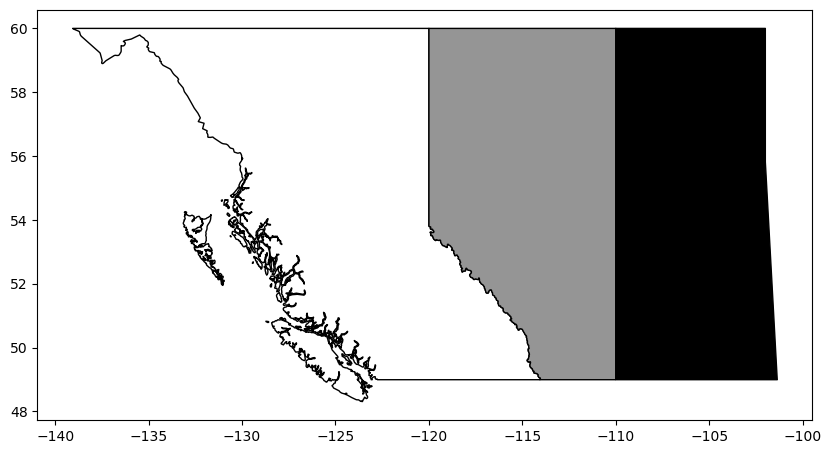

In [30]:
fig, ax = plt.subplots(figsize=(10,8))
ab_bc_ma_map.plot(ax=ax, edgecolor='black', linewidth=1, cmap='Greys')
gdf_buffered.plot(ax=ax, linewidth=10, color='red')
NBAC_23.plot(ax=ax, linewidth=10, color='black')
gdf_NOAA20.plot(ax=ax, color="blue", markersize=1)
NFDB_sep_23.plot(ax=ax, color="yellow", markersize=10)

blue_patch = mpatches.Patch(color='blue', label='NOAA20')
black_patch = mpatches.Patch(color='black', label='2023 NBAC')
red_dots = mpatches.Patch(color='red', label='NBAC Buffer 5 km')
yellow = mpatches.Patch(color='yellow', label='NFDB Sep 2023 Fires')
ax.legend(handles=[blue_patch, black_patch, red_dots, yellow])

#plt.legend()
plt.ylim((56.5, 58.3))
plt.xlim((-123.2, -120))
plt.show()

## CFSDS (Unrelated to Plumes, Just for Interest)

This dataset only goes to 2021 so just for reference

### Point Data

In [ ]:
df_CFSDS = pd.read_csv(r'C:\Users\kzammit\Documents\Shapefiles\CFSDS\Firegrowth_pts_v1_01_2021.csv')
gdf_CFSDS = gpd.GeoDataFrame(
    df_CFSDS, geometry=gpd.points_from_xy(df_CFSDS.lon, df_CFSDS.lat), crs="EPSG:4326"
)
gdf_CFSDS.head(3)

In [ ]:
#gdf_CFSDS['ID'].unique()
# Make subset dataframe for a specific example fire
gdf_202133 = gdf_CFSDS[gdf_CFSDS['ID']=='2021_33']
print(gdf_202133.head())

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
shp_map_cad.plot(ax=ax, edgecolor='black', linewidth=1, cmap='Greys')
gdf_CFSDS.plot(ax=ax, linewidth=1, color='red')
gdf_202133.plot(ax=ax, linewidth=1, color='yellow')

red_patch = mpatches.Patch(color='red', label='CFSDS')
yellow_patch = mpatches.Patch(color='yellow', label='2021_33')
plt.title('CFSDS Fires')
ax.legend(handles=[red_patch, yellow_patch])

### Tif Data

In [ ]:
# read in a GEOTif
krig = rxr.open_rasterio(r'C:\Users\kzammit\Documents\Shapefiles\CFSDS\2021_33\2021_33_krig.tif')

# Get the bounds of the tif
krig.rio.bounds()

print("The crs of your data is:", krig.rio.crs)
print("The nodatavalue of your data is:", krig.rio.nodata)
print("The shape of your data is:", krig.shape)
print("The spatial resolution for your data is:", krig.rio.resolution())
print("The metadata for your data is:", krig.attrs)

et.epsg['']

In [ ]:
# Reproject into EPSG 4326
krig_4326 = krig.rio.reproject("EPSG:4326")
type(krig_4326)
krig_4326.rio.crs

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
krig.plot(ax=axes[0])
krig_4326.plot(ax=axes[1])

titles = ['EPSG4249/NAD83', 'EPSG4326/WGS84']
for i, ax in enumerate(axes.ravel()):
    ax.set_title(str(titles[i]))

fig.tight_layout()

In [ ]:
# Plot on a map of Canada
fig, ax = plt.subplots(figsize=(10,8))
shp_map_cad.plot(ax=ax, edgecolor='black', linewidth=1, cmap='Greys')
krig_4326.plot(ax=ax, linewidth=1, label='2021_33')
black_patch = mpatches.Patch(color='black', label='NWT')
grey_patch = mpatches.Patch(color='#7E7E7E', label='YT')
plt.title('2021_33')
ax.legend(handles=[black_patch, grey_patch])